# Applying aPMV setpoints

## Introduction

This notebook demonstrates how to use the `accim` library to implement **Adaptive Predicted Mean Vote (aPMV)** control strategies in EnergyPlus models. 

The aPMV model extends the standard Fanger PMV model by introducing an adaptive coefficient ($\lambda$). This coefficient accounts for the psychological, physiological, and behavioral adaptations of occupants in naturally ventilated or mixed-mode buildings. By dynamically adjusting HVAC setpoints based on aPMV, we can often achieve thermal comfort with lower energy consumption compared to static setpoints.

## Objectives of this Notebook

1.  **Setup:** Load a residential EnergyPlus model and prepare it for simulation.
2.  **Inspect:** Identify the valid control targets (Zones/Spaces) within the model.
3.  **Base Case (PMV):** Simulate the building using standard PMV logic ($\lambda = 0$).
4.  **Adaptive Case (aPMV):** Simulate the building using adaptive logic with custom coefficients for specific zones.
5.  **Compare:** Analyze the differences in setpoints and comfort between the two strategies.

## 1. Setup and Imports

We import the necessary libraries for simulation (`besos`, `accim`) and data analysis (`pandas`, `matplotlib`, `seaborn`).

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from besos import eppy_funcs as ef
from besos import eplus_funcs as ep

# Import the accim module
# Ensure the accim library is in your python path or current directory
import accim.sim.apmv_setpoints_wip_4_4_works_doc as apmv

# Visualization setup
plt.rcParams['figure.figsize'] = [14, 6]
sns.set_style("whitegrid")

# Define file paths
idf_filename = "TestModel_TestResidentialUnit.idf"
epw_filename = "Seville.epw"

# Check files
if not os.path.exists(idf_filename):
    print(f"⚠️ Warning: {idf_filename} not found.")
else:
    print(f"✅ Model found: {idf_filename}")

✅ Model found: TestModel_TestResidentialUnit.idf


## 2. Loading the Model

We use BESOS to load the IDF file. This creates a building object that we can manipulate in memory.

In [2]:
# Load initial instance for inspection
building = ef.get_building(idf_filename)

## 3. Model Preparation (Occupancy)

To ensure the adaptive control logic is active and visible throughout the simulation period, we need to ensure the zones are occupied. The `accim` library provides a helper function to force occupancy schedules to 'Always On'.

**Note:** The `apply_apmv_setpoints` function requires the model to have an existing HVAC system (specifically, `ZoneControl:Thermostat` objects) to function correctly. For this demonstration, we assume the loaded IDF already contains a heating/cooling system.

In [3]:
# Set Occupancy to 'Always On' to ensure continuous control
print("--- Setting Occupancy ---")
apmv.set_zones_always_occupied(building=building, verbose_mode=True)

--- Setting Occupancy ---
Added Schedule: On
Updated all People objects to use schedule 'On'.


## 4. Implementing aPMV setpoints

The core function of this module is `apply_apmv_setpoints`. This function injects Energy Management System (EMS) code into the IDF to calculate setpoints dynamically.

### Key Parameters:
*   **`adap_coeff_cooling` / `_heating`**: The adaptive coefficient ($\lambda$).
    *   If $\lambda = 0$, the logic mimics standard Fanger PMV.
    *   If $\lambda > 0$, the logic applies adaptive comfort (usually widening the comfort band).
    *   Can be a single `float` (global) or a `dict` (per zone).
*   **`pmv_cooling_sp` / `_heating_sp`**: The target PMV index (e.g., +0.5 for cooling, -0.5 for heating).
*   **`tolerance_...`**: Additional deadbands applied to the calculated setpoint.
    *   **Default value:** `0.1`.
    *   **How it works:** The tolerance tightens the setpoint range to create a safety margin. For example, if you specify a `pmv_cooling_sp` of **0.5**, the effective setpoint used in the simulation will be **0.4** ($0.5 - 0.1$). Similarly, for a `pmv_heating_sp` of **-0.5**, the effective setpoint becomes **-0.4** ($-0.5 + 0.1$).
    *   **Purpose:** This ensures that all simulation hours remain strictly within the desired limits, preventing situations where setpoints are exceeded by small fractions (tenths or hundredths).

### Inspecting Targets

Before applying the logic, we must know **where** to apply it. The function `get_available_target_names` scans the model for People objects and returns the valid keys (Zone or Space names) to use in our configuration.

In [4]:
# Identify valid targets in the model
target_names = apmv.get_available_target_names(building=building)

print(f"Found {len(target_names)} targets:")
for t in target_names:
    print(f" - {t}")

Found 2 targets:
 - Floor_1 Residential Living Occupants
 - Floor_2 Residential Living Occupants


### Generating an Input Template

Most parameters in `accim` (such as adaptive coefficients $\lambda$, setpoints, or tolerances) can be configured **independently for each zone**.

To do this, instead of passing a single number (which applies globally), you pass a **dictionary** following the pattern `{'Target Name': value}`.

If you are unsure of the exact keys to use, the function `get_input_template_dictionary` generates a blank dictionary containing all valid target keys found in your model.

In [5]:
# Generate a template dictionary
template = apmv.get_input_template_dictionary(building=building)

print("Template dictionary structure:")
print(template)

Template dictionary structure:
{'Floor_1 Residential Living Occupants': 'replace-me-with-float-value', 'Floor_2 Residential Living Occupants': 'replace-me-with-float-value'}


### 4.1 Base case

#### 4.1.1 Implementing PMV setpoints

In this section, we generate the **Base Case**. We will use the `apply_apmv_setpoints` function, but we will set the adaptive coefficients (`adap_coeff_cooling` and `adap_coeff_heating`) to **0**.

Mathematically, if $\lambda = 0$, then $aPMV = PMV$. This effectively simulates a standard Fanger PMV control strategy.

In [6]:
# 1. Reload model to ensure a clean state
building_base = ef.get_building(idf_filename)
apmv.set_zones_always_occupied(building_base, verbose_mode=False)

In [7]:
# 2. Apply PMV logic (Lambda = 0)
print("Applying Base Case (PMV) logic...")
building_base = apmv.apply_apmv_setpoints(
    building=building_base,
    adap_coeff_cooling=0,  # Zero means standard PMV
    adap_coeff_heating=0,  # Zero means standard PMV
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/05',
    cooling_season_end='30/09',
    verbose_mode=False
)

Applying Base Case (PMV) logic...


#### 4.1.2 PMV setpoints simulation

We run the simulation for the base case and store the results.

In [8]:
out_dir_base = 'sim_results_base'
print(f"Running Base Case simulation in {out_dir_base}...")

ep.run_building(
    building=building_base,
    out_dir=out_dir_base,
    epw=epw_filename
)
print("Base simulation finished.")

Running Base Case simulation in sim_results_base...
Running EnergyPlus with stdout output suppressed...
Base simulation finished.


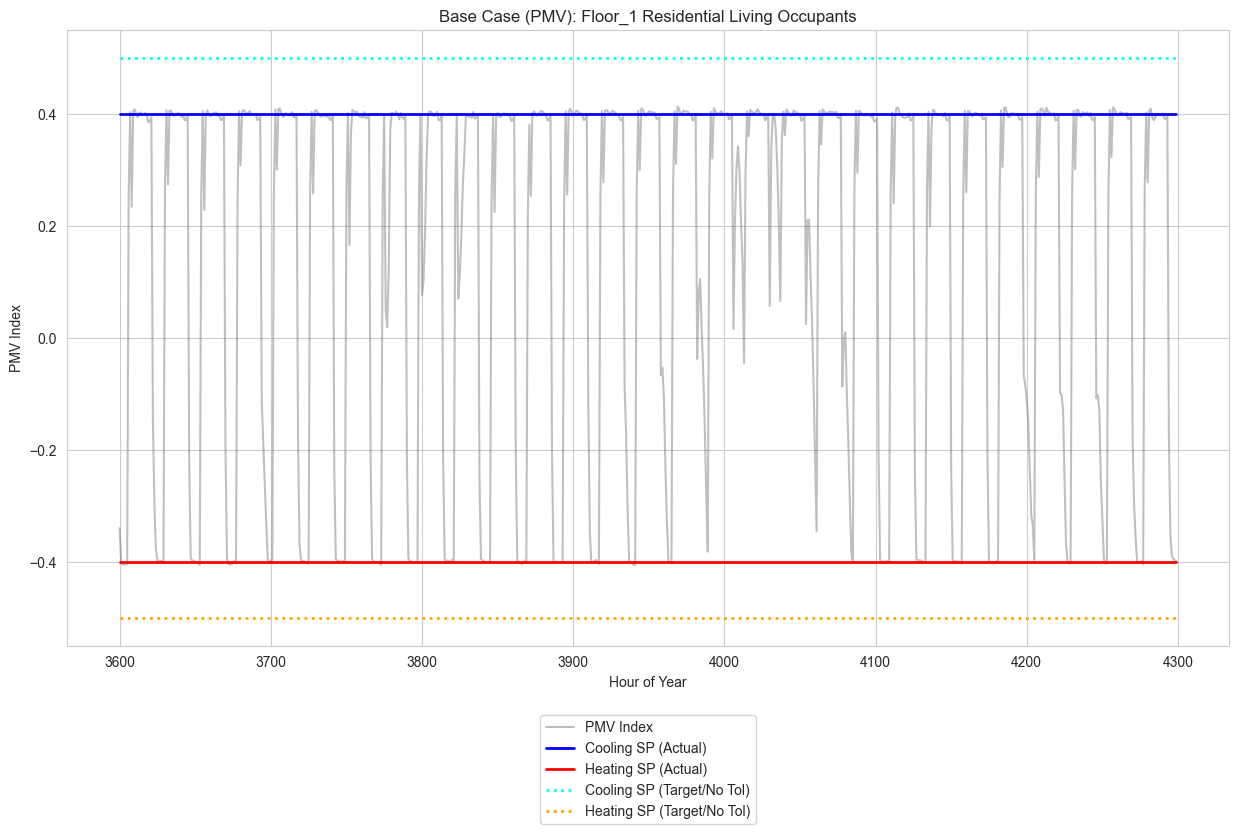

In [15]:
# Load Base Results
df_base = pd.read_csv(os.path.join(out_dir_base, 'eplusout.csv'))
df_base['Hour'] = df_base.index

# Visualize Zone 1 (Example)
target_zone = target_names[0].replace(" ", "_").replace(":", "_") # Sanitize name for column search

plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
start_h = 3600
end_h = 4300
subset = df_base.iloc[start_h:end_h]

try:
    # 1. Identify Columns
    # Actual PMV Value
    col_pmv = [c for c in df_base.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]

    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_base.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_base.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_base.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_base.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_pmv], label='PMV Index', color='gray', alpha=0.5)

    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Base Case (PMV): {target_names[0]}")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
    plt.show()
    plt.show()

except IndexError:
    print("Could not find output columns. Check simulation results.")

### 4.2 aPMV setpoints implemented case

#### 4.2.1 Implementing aPMV setpoints

Now we generate the **Adaptive Case**. We will define specific adaptive coefficients for our zones.

*   **Floor_1 Residential Living Occupants:** High adaptation ($\lambda = 0.4$).
*   **Floor_2 Residential Living Occupants:** Low adaptation ($\lambda = 0.1$).

In [37]:
# 1. Reload model fresh
building_apmv = ef.get_building(idf_filename)
apmv.set_zones_always_occupied(building_apmv, verbose_mode=False)

In [38]:
custom_coeffs = apmv.get_input_template_dictionary(building=building_apmv)
print(custom_coeffs)

{'Floor_1 Residential Living Occupants': 'replace-me-with-float-value', 'Floor_2 Residential Living Occupants': 'replace-me-with-float-value'}


In [39]:
for k, v in custom_coeffs.items():
    if 'Floor_1 Residential Living Occupants' == k:
        custom_coeffs[k] = 0.4
    elif 'Floor_2 Residential Living Occupants' == k:
        custom_coeffs[k] = 0.1

print(custom_coeffs)

{'Floor_1 Residential Living Occupants': 0.4, 'Floor_2 Residential Living Occupants': 0.1}


In [40]:
# 3. Apply aPMV logic
print("Applying Adaptive Case (aPMV) logic...")
building_apmv = apmv.apply_apmv_setpoints(
    building=building_apmv,
    adap_coeff_cooling=custom_coeffs,
    adap_coeff_heating=-0.3, # Global value for heating
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/05',
    cooling_season_end='30/09',
    verbose_mode=False
)

Applying Adaptive Case (aPMV) logic...


#### 4.2.2 aPMV setpoints simulation

We run the simulation for the adaptive case.

In [41]:
out_dir_apmv = 'sim_results_apmv'
print(f"Running Adaptive Case simulation in {out_dir_apmv}...")

ep.run_building(
    building=building_apmv,
    out_dir=out_dir_apmv,
    epw=epw_filename
)
print("Adaptive simulation finished.")

Running Adaptive Case simulation in sim_results_apmv...
Running EnergyPlus with stdout output suppressed...
Adaptive simulation finished.


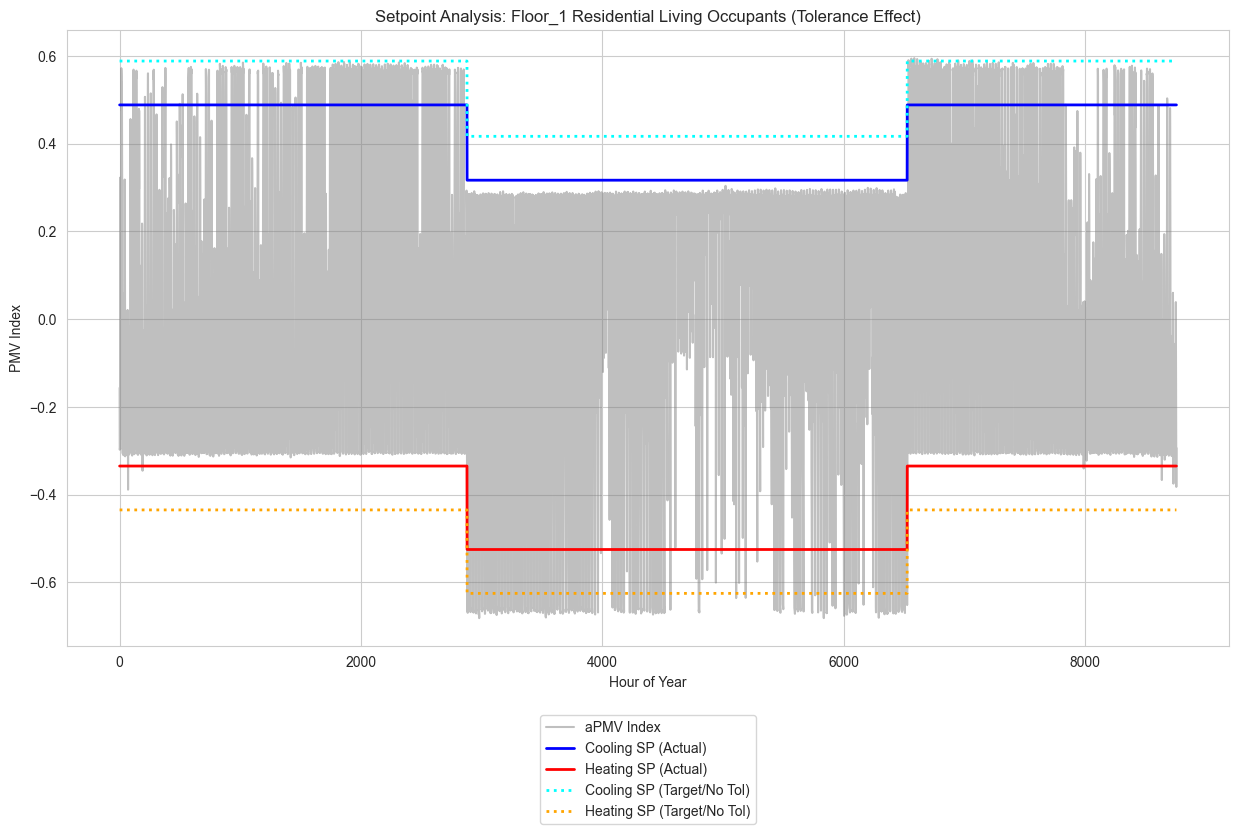

In [42]:
# Load aPMV Results
df_apmv = pd.read_csv(os.path.join(out_dir_apmv, 'eplusout.csv'))
df_apmv['Hour'] = df_apmv.index

# Visualize Zone 1 (Example)
target_zone = target_names[0].replace(" ", "_").replace(":", "_") # Sanitize name for column search
plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
# start_h = 3600
# end_h = 4300
# subset = df_apmv.iloc[start_h:end_h]
subset = df_apmv


try:
    # 1. Identify Columns
    # Actual aPMV Value
    col_apmv = [c for c in df_base.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]
    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_apmv], label='aPMV Index', color='gray', alpha=0.5)
    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Setpoint Analysis: {target_names[0]} (Tolerance Effect)")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
    plt.show()

except IndexError:
    print("Error: Could not find matching columns for comparison.")

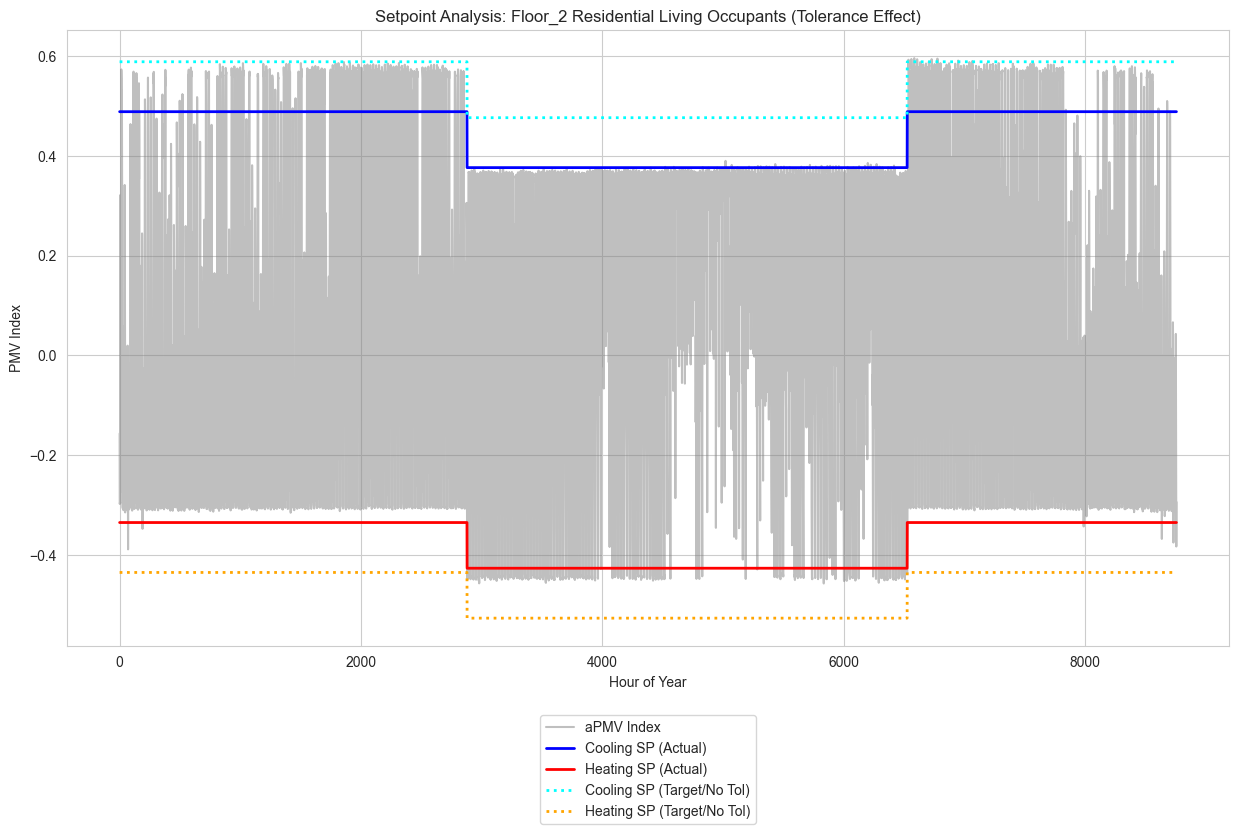

In [43]:
# Load aPMV Results
df_apmv = pd.read_csv(os.path.join(out_dir_apmv, 'eplusout.csv'))
df_apmv['Hour'] = df_apmv.index

# Visualize Zone 1 (Example)
target_zone = target_names[1].replace(" ", "_").replace(":", "_") # Sanitize name for column search
plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
# start_h = 3600
# end_h = 4300
# subset = df_apmv.iloc[start_h:end_h]
subset = df_apmv


try:
    # 1. Identify Columns
    # Actual aPMV Value
    col_apmv = [c for c in df_base.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]
    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_apmv], label='aPMV Index', color='gray', alpha=0.5)
    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Setpoint Analysis: {target_names[1]} (Tolerance Effect)")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
    plt.show()

except IndexError:
    print("Error: Could not find matching columns for comparison.")

## 5. Results comparison

In this section, we compare the Cooling Setpoints generated by the Base Case (PMV) versus the Adaptive Case (aPMV).

We expect the **aPMV setpoint** (green) to be higher (less strict) than the **PMV setpoint** (blue) during warm periods, as the adaptive model accounts for the occupants' ability to tolerate warmer temperatures.

In [44]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# =============================================================================

# Definir rutas de los resultados generados en pasos anteriores
path_pmv = os.path.join('sim_results_base', 'eplusout.csv')
path_apmv = os.path.join('sim_results_apmv', 'eplusout.csv')

try:
    # Cargar DataFrames
    df_pmv = pd.read_csv(path_pmv)
    df_pmv['Source'] = 'PMV'

    df_apmv = pd.read_csv(path_apmv)
    df_apmv['Source'] = 'aPMV'

    # Concatenar
    df = pd.concat([df_pmv, df_apmv], ignore_index=True)

    # Limpieza de nombres de columnas (eliminar unidades y corchetes)
    df.columns = df.columns.str.replace(r'\s*\[.*?\]\(Hourly\)?', '', regex=True)
    df.columns = df.columns.str.strip()

    # --- Identificación Dinámica de Columnas ---
    # 1. Columna aPMV: Usamos la primera zona identificada en el notebook
    # Sanitizamos el nombre igual que hace el EMS (espacios -> guiones bajos)
    target_zone_sanitized = target_names[0].replace(" ", "_").replace(":", "_")

    # Buscamos la columna que contenga 'EMS:aPMV' y el nombre de la zona
    apmv_cols = [c for c in df.columns if 'EMS:aPMV' in c and target_zone_sanitized in c and 'Setpoint' not in c]
    if not apmv_cols:
        raise KeyError(f"No se encontró columna aPMV para {target_zone_sanitized}")
    apmv_col = apmv_cols[0]

    # 2. Columna Energía: Buscamos 'Electricity:Facility' o similar
    # Nota: En el script original se dividía por área. Aquí mostramos consumo total (Wh) o kW según salida.
    elec_cols = [c for c in df.columns if 'Electricity:Facility' in c]
    if elec_cols:
        hvac_col = elec_cols[0]
        # Convertir a Wh/m2 si conoces el área, si no, dejamos como Total Wh
        # Asumimos un área ejemplo de 100m2 para mantener la escala del gráfico original, o usamos valor crudo.
        # Para este demo, usaremos el valor crudo pero cambiaremos la etiqueta.
        df['HVAC Consumption'] = df[hvac_col]
        y_label = 'Total Electricity Consumption (J or Wh)'
    else:
        raise KeyError("No se encontró columna de Electricidad (Electricity:Facility)")

    print(f"Graficando: {apmv_col} vs {hvac_col}")

except FileNotFoundError:
    print("⚠️ Error: No se encontraron los archivos de resultados. Asegúrate de haber ejecutado las simulaciones (Pasos 4.1.2 y 4.2.2).")
except KeyError as e:
    print(f"⚠️ Error de datos: {e}")

else:
    # =============================================================================
    # 2. GENERACIÓN DE LA FIGURA
    # =============================================================================

    # Configuración del estilo
    sns.set_theme(style="whitegrid")
    sns.set_context("talk", font_scale=0.9)

    # Crear el jointplot
    g2 = sns.jointplot(
        data=df,
        x=apmv_col,
        y='HVAC Consumption',
        hue='Source',
        palette='viridis',
        height=8,
        joint_kws={'alpha': 0.5, 's': 40},
        marginal_kws={'fill': True, 'common_norm': False}
    )

    ax2 = g2.ax_joint

    # --- Calcular Setpoints Teóricos para las líneas ---
    # PMV Base: -0.5 y 0.5
    # aPMV Adaptativo: Calculado con Lambda = 0.4 (usado en el tutorial para la Zona 1)
    # Formula: SP_aPMV = SP_PMV / (1 + lambda * SP_PMV)
    lambda_val = 0.4
    apmv_cool_sp = 0.5 / (1 + lambda_val * 0.5)   # aprox 0.416
    apmv_heat_sp = -0.5 / (1 + lambda_val * -0.5) # aprox -0.625

    # Añadir líneas verticales
    ax2.axvline(x=-0.5, linestyle="--", color="black", label='PMV heating SP (-0.5)')
    ax2.axvline(x=0.5, linestyle="--", color="grey", label='PMV cooling SP (0.5)')
    ax2.axvline(x=apmv_heat_sp, linestyle="-", color="blue", label=f'aPMV heating SP ({apmv_heat_sp:.2f})')
    ax2.axvline(x=apmv_cool_sp, linestyle="-", color="red", label=f'aPMV cooling SP ({apmv_cool_sp:.2f})')

    # Etiquetas
    g2.set_axis_labels('PMV / aPMV Index', y_label, fontsize=14)

    # --- LEYENDAS PERSONALIZADAS ---
    handles, labels = ax2.get_legend_handles_labels()
    if ax2.get_legend(): ax2.get_legend().remove()
    g2.fig.subplots_adjust(bottom=0.25)

    # Separar handles (Scatter vs Líneas)
    # Los primeros N handles son del scatter (Source), el resto son las líneas
    n_sources = len(df['Source'].unique())

    g2.fig.legend(handles[:n_sources], labels[:n_sources], loc='lower center', bbox_to_anchor=(0.3, 0.02), title='Model')
    g2.fig.legend(handles[n_sources:], labels[n_sources:], loc='lower center', bbox_to_anchor=(0.7, -0.05), title='Setpoints')

    plt.show()

⚠️ Error de datos: 'No se encontró columna de Electricidad (Electricity:Facility)'


## 6. Conclusion

This notebook demonstrated the implementation of the `accim` library to apply adaptive comfort control.

1.  We successfully identified control targets using `get_available_target_names`.
2.  We simulated a **Base Case** where $\lambda=0$, resulting in static PMV setpoints.
3.  We simulated an **Adaptive Case** where $\lambda=0.4$, resulting in dynamic setpoints that relax the cooling requirements during warm periods.
4.  The comparison shows that the aPMV logic effectively widens the comfort band, which typically leads to significant energy savings while maintaining occupant satisfaction according to the adaptive model.